# Introduction to XGCM

Before we get started, you may choose to run this notebook on LEAP-Pangeo hub or Binder!

<a href="https://leap.2i2c.cloud/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fm2lines%2Fdata-gallery&urlpath=lab%2Ftree%2Fdata-gallery%2Fsrc%2Fnotebooks%2Fxgcm_intro.ipynb&branch=main"><img src="https://custom-icon-badges.demolab.com/badge/LEAP-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:30px;"></a>

<a href="https://mybinder.org/v2/gh/m2lines/data-gallery/main?labpath=src%2Fnotebooks%2Fxgcm_intro.ipynb"><img src="https://custom-icon-badges.demolab.com/badge/Binder-Launch%20%F0%9F%9A%80-blue?style=for-the-badge&logo=leap-globe" style="height:28px;"></a>

[Xgcm](https://xgcm.readthedocs.io/en/latest/index.html) is a python packge for working with the datasets produced by numerical General Circulation Models (GCMs) and similar gridded datasets that are amenable to finite volume analysis. In these datasets, different variables are located at different positions with respect to a volume or area element (e.g. cell center, cell face, etc.) xgcm solves the problem of how to interpolate and difference these variables from one position to another.

xgcm consumes and produces xarray data structures, which are coordinate and metadata-rich representations of multidimensional array data. xarray is ideal for analyzing GCM data in many ways, providing convenient indexing and grouping, coordinate-aware data transformations, and (via dask) parallel, out-of-core array computation. On top of this, xgcm adds an understanding of the finite volume Arakawa Grids commonly used in ocean and atmospheric models and differential and integral operators suited to these grids.

In [2]:
import xarray as xr
import numpy as np
import xgcm
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)

## Axis 

A fundamental concept in xgcm is the notion of an “axis”. An axis is a group of coordinates that all lie along the same physical dimension but describe different positions relative to a grid cell. There are currently five possible positions supported by xgcm.

center
The variable values are located at the cell center.

left
The variable values are located at the left (i.e. lower) face of the cell.

right
The variable values are located at the right (i.e. upper) face of the cell.

inner
The variable values are located on the cell faces, excluding both outer boundaries.

outer
The variable values are located on the cell faces, including both outer boundaries.

The first three (center, left, and right) all have the same length along the axis dimension, while inner has one fewer point and outer has one extra point. These positions are visualized in the figure below.

<img src="https://xgcm.readthedocs.io/en/latest/_images/axis_positions.svg" style="width:300;height:300px;">

Although it is technically possible to create an Axis directly, the recommended way to to use xgcm is by creating a single xgcm.Grid object, containing multiple axes for each physical dimension.


In [7]:
ds = xr.Dataset(
    coords={
        "x_center": (
            ["x_center"],
            np.arange(1, 10),
        ),
        "x_left": (
            ["x_left"],
            np.arange(0.5, 9),
        ),
    },
)
ds

<xarray.Dataset>
Dimensions:   (x_center: 9, x_left: 9)
Coordinates:
  * x_center  (x_center) int64 1 2 3 4 5 6 7 8 9
  * x_left    (x_left) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5
Data variables:
    *empty*

Let us now create a grid using ds. xarray has no idea that x_center and x_left are related to each other; they are subject to standard xarray broadcasting rules. When we create an xgcm.Grid, we need to specify that they are part of the same axis. We do this using the coords keyword argument, as follows:

In [17]:
from xgcm import Grid

grid = Grid(ds, coords={"X": {"center": "x_center", "left": "x_left"}})
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x_center --> left
  * left     x_left --> center

The printed information about the grid indicates that xgcm has successfully understood the relative location of the different coordinates along the x axis. Because we did not specify the periodic keyword argument, xgcm assumed that the data is periodic along all axes. The arrows after each coordinate will be explained later.

If coords is not specified, xgcm looks for metadata in the coordinate attributes. The key attribute xgcm looks for is axis. When creating a new grid, xgcm will search through the dataset dimensions looking for dimensions with the axis attribute defined. 

To determine the positions of the different coordinates, xgcm considers both the length of the coordinate variable and the c_grid_axis_shift attribute, which determines the position of the coordinate with respect to the cell center.

The only acceptable values of c_grid_axis_shift are -0.5 and 0.5. If the c_grid_axis_shift attribute attribute is absent, the coordinate is assumed to describe a cell center. 

The cell center coordinate is identified first; the length of other coordinates relative to the cell center coordinate is used in conjunction with c_grid_axis_shift to infer the coordinate positions

| length | c_grid_axis_shift | position |
| --- | --- | --- |
| n | None | center |
| n | -0.5 | left |
| n | 0.5 | right |
| n-1 | 0.5 / -0.5 | inner |
| n+1 | 0.5 / -0.5 | outer |

In [21]:
ds = xr.Dataset(
    coords={
        "x_center": (
            ["x_center"],
            np.arange(1, 10),
            {"axis": "X"},
        ),
        "x_left": (
            ["x_left"],
            np.arange(0.5, 9),
            {"axis": "X", "c_grid_axis_shift": -0.5},
        ),
    }
)
ds

<xarray.Dataset>
Dimensions:   (x_center: 9, x_left: 9)
Coordinates:
  * x_center  (x_center) int64 1 2 3 4 5 6 7 8 9
  * x_left    (x_left) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5
Data variables:
    *empty*

In [23]:
grid = Grid(ds)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x_center --> left
  * left     x_left --> center

The arrows after each coordinate indicate the default shift positions for **interpolation and difference operations**: operating on the center coordinate (x_center) shifts to the left coordinate (x_left), and vice versa. What are these operations? To understand them deeper, we need to introduce the concept of Arakawa grids.

## Arakawa grids

Most finite volume ocean models use Arakawa Grids, in which different variables are offset from one another and situated at different locations with respect to the cell center and edge points. As an example, we will consider C-grid geometry. As illustrated in the figure below, C-grids place scalars (such as temperature) at the cell center and vector components (such as velocity) at the cell faces.

<img src="https://xgcm.readthedocs.io/en/latest/_images/grid2d_hv.svg" style="width:300;height:300px;">


These grids present a dilemma for the xarray data model. The u and t points in the example above are located at different points along the x-axis, meaning they can’t be represented using a single coordinate. But they are clearly related and can be transformed via well defined interpolation and difference operators. One goal of xgcm is to provide these interpolation and difference operators.

The difference operator is defined as

$$\delta_x \phi = \phi_{x_{right}} - \phi_{x_{left}}$$

The interpolation operator is defined as

$$ \overline \phi = \frac{\phi_{x_{right}} + \phi_{x_{left}}}{2}$$

where $\phi$ is a generic variable and $x_{right}$ and $x_{left}$ are the right and left positions of the variable along the x-axis. 

Both operators return a variable that is shifted by half a gridpoint with respect to the input variable. With these two operators, the entire suite of finite volume vector calculus operations can be represented.

### Transforms

An example on how to use XGCM Grid transforms can be found an example to calculate [Pycnocline depth](pycnocline_depth_mom6.ipynb)

## Core grid operations

In [33]:
da = np.sin(ds.x_center * 2 * np.pi / 9)
da

<xarray.DataArray 'x_center' (x_center: 9)>
array([ 6.42787610e-01,  9.84807753e-01,  8.66025404e-01,  3.42020143e-01,
       -3.42020143e-01, -8.66025404e-01, -9.84807753e-01, -6.42787610e-01,
       -2.44929360e-16])
Coordinates:
  * x_center  (x_center) int64 1 2 3 4 5 6 7 8 9

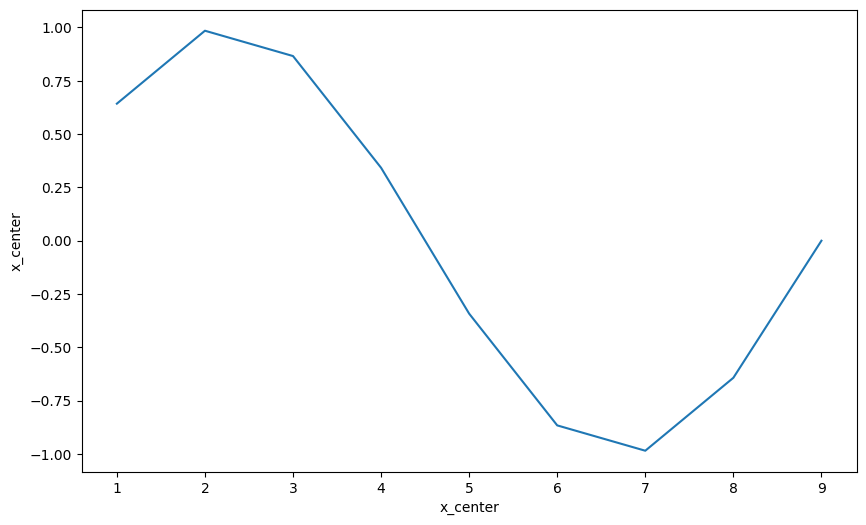

In [36]:
da.plot();

In [37]:
plt.close()

In [38]:
da_interp = grid.interp(da, axis="X")
da_interp

<xarray.DataArray 'x_center' (x_left: 9)>
array([ 3.21393805e-01,  8.13797681e-01,  9.25416578e-01,  6.04022774e-01,
        1.11022302e-16, -6.04022774e-01, -9.25416578e-01, -8.13797681e-01,
       -3.21393805e-01])
Coordinates:
  * x_left   (x_left) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5

We see that the output is on the x_left points rather than the original x_center points.

### Interpolation

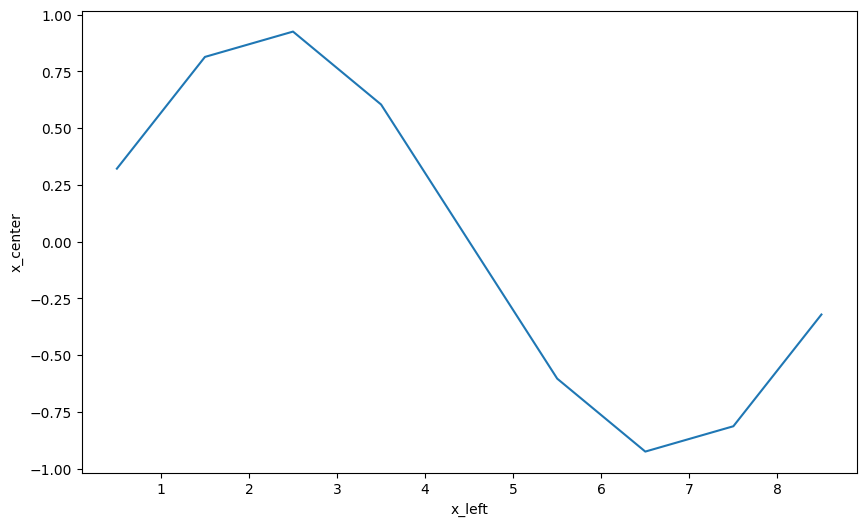

In [39]:
da_interp.plot();

Notice the position shift of the output. 

Let us now verify using our own calculations.

In [60]:
# check if difference is very close
assert np.isclose(da_interp[0], (da[0] / 2))
for i in range(1, 9):
    assert np.isclose(da_interp[i], (da[i - 1] + da[i]) / 2)

### Difference

In [75]:
da_diff = grid.diff(da, axis="X")
da_diff

<xarray.DataArray 'x_center' (x_left: 9)>
array([ 0.64278761,  0.34202014, -0.11878235, -0.52400526, -0.68404029,
       -0.52400526, -0.11878235,  0.34202014,  0.64278761])
Coordinates:
  * x_left   (x_left) float64 0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5

In [77]:
# check if difference is very close
assert np.isclose(da_diff[0], da[0])
for i in range(1, 9):
    assert np.isclose(da_diff[i], da[i] - da[i - 1])

# Can also use cumsum
assert np.isclose(da, grid.cumsum(da_diff, "X")).all()

## Complex Grid Topologies 

All the grids considered till now were a single logically rectangular domain. Many modern GCMs use more complex grid topologies, consisting of multiple logically rectangular grids connected at their edges. In order to construct a complex grid topology, we need a way to tell xgcm about the connections between faces.

xgcm is capable of understanding the connections between these grid faces and exchanging data between them appropriately.

<img src="https://xgcm.readthedocs.io/en/latest/_images/cubed_sphere.jpeg" style="width:300;height:300px;">


### Two connected faces

In [79]:
N = 25
ds = xr.Dataset(
    {"data_c": (["face", "y", "x"], np.random.rand(2, N, N))},
    coords={
        "x": (("x",), np.arange(N), {"axis": "X"}),
        "xl": (
            ("xl"),
            np.arange(N) - 0.5,
            {"axis": "X", "c_grid_axis_shift": -0.5},
        ),
        "y": (("y",), np.arange(N), {"axis": "Y"}),
        "yl": (
            ("yl"),
            np.arange(N) - 0.5,
            {"axis": "Y", "c_grid_axis_shift": -0.5},
        ),
        "face": (("face",), [0, 1]),
    },
)
ds

<xarray.Dataset>
Dimensions:  (face: 2, y: 25, x: 25, xl: 25, yl: 25)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * xl       (xl) float64 -0.5 0.5 1.5 2.5 3.5 4.5 ... 19.5 20.5 21.5 22.5 23.5
  * y        (y) int64 0 1 2 3 4 5 6 7 8 9 10 ... 15 16 17 18 19 20 21 22 23 24
  * yl       (yl) float64 -0.5 0.5 1.5 2.5 3.5 4.5 ... 19.5 20.5 21.5 22.5 23.5
  * face     (face) int64 0 1
Data variables:
    data_c   (face, y, x) float64 0.8044 0.5242 0.03828 ... 0.7809 0.7157 0.6126

The face_connections dictionary has the following general stucture: 

```
face_connections = {'<FACE DIMENSION NAME>':
    {<FACE DIMENSION VALUE>:
         {'<AXIS NAME>': (<LEFT CONNECTION>, <RIGHT CONNECTION>),
          ...}
    ...
}
```

```<LEFT CONNECTION>``` and ```<RIGHT CONNECTION>``` are either None (for no connection) or a three element tuple with the following contents

```
(<FACE DIMENSION VALUE>, <AXIS NAME>, <REVERSE CONNECTION>)
```

```<FACE DIMENSION VALUE>``` tells which face this face is connected to. ```<AXIS NAME>``` tells which axis on that face is connected to this one. ```<REVERSE CONNECTION>``` is a boolean specifying whether the connection is “reversed”.



Simple example : The dataset has two spatial axes (X and Y), plus an additional dimension face of length 2. Let’s imagine the two faces are joined in the following way:

<img src="https://xgcm.readthedocs.io/en/stable/_images/two_faces.png" style="width:20;height:20;">

In [82]:
face_connections = {
    "face": {0: {"X": (None, (1, "X", False))}, 1: {"X": ((0, "X", False), None)}}
}
grid = xgcm.Grid(ds, face_connections=face_connections)
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   x --> left
  * left     xl --> center
Y Axis (periodic, boundary=None):
  * center   y --> left
  * left     yl --> center

The face_connections dictionary tells xgcm that face is the name of the dimension that contains the different faces. This dictionary say that face number 0 is connected along the X axis to nothing on the left and to face number 1 on the right. A complementary connection exists from face number 1.

## Example Dataset : mitgcm

In [4]:
# download the data
import urllib.request
import shutil

url = "https://zenodo.org/record/4421428/files/"
file_name = "mitgcm_example_dataset_v2.nc"
save_file_name = "dataset_" + file_name
with urllib.request.urlopen(url + file_name) as response, open(
    save_file_name, "wb"
) as out_file:
    shutil.copyfileobj(response, out_file)

# open the data
ds = xr.open_dataset(save_file_name)
ds

<xarray.Dataset>
Dimensions:  (time: 1, Z: 15, YC: 40, XG: 90, YG: 40, XC: 90, Zl: 15)
Coordinates: (12/25)
  * time     (time) timedelta64[ns] 11:00:00
    maskC    (Z, YC, XC) bool ...
    dyC      (YG, XC) float32 ...
    hFacC    (Z, YC, XC) float32 ...
    rA       (YC, XC) float32 ...
    hFacS    (Z, YG, XC) float32 ...
    ...       ...
    rAs      (YG, XC) float32 ...
    rAz      (YG, XG) float32 ...
    maskS    (Z, YG, XC) bool ...
    dxC      (YC, XG) float32 ...
    hFacW    (Z, YC, XG) float32 ...
  * XC       (XC) float32 2.0 6.0 10.0 14.0 18.0 ... 346.0 350.0 354.0 358.0
Data variables:
    UVEL     (time, Z, YC, XG) float32 ...
    VVEL     (time, Z, YG, XC) float32 ...
    WVEL     (time, Zl, YC, XC) float32 ...
    SALT     (time, Z, YC, XC) float32 ...
    THETA    (time, Z, YC, XC) float32 ...
    PH       (time, Z, YC, XC) float32 ...
    Eta      (time, YC, XC) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(extra_metadata=None, ll...

Next we create a Grid object from the dataset. We need to tell xgcm that the X and Y axes are periodic. (The other axes will be assumed to be non-periodic.)

In [5]:
grid = xgcm.Grid(ds, periodic=["X", "Y"])
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> left
  * left     Zl --> center
Y Axis (periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
T Axis (not periodic, boundary=None):
  * center   time